In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import pandas as pd
import pickle
from datasets import load_dataset

In [20]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


In [21]:
# load a dataset using datasets library
dataset = load_dataset("SetFit/emotion")

Found cached dataset json (/home/illia-st/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [23]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [24]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [25]:
tweets, labels = get_tweet(train)
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

In [26]:
# we use tokenizer to convert our words into number
from tensorflow.keras.preprocessing.text import Tokenizer

In [27]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [28]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [29]:
tweets[0]

'i didnt feel humiliated'

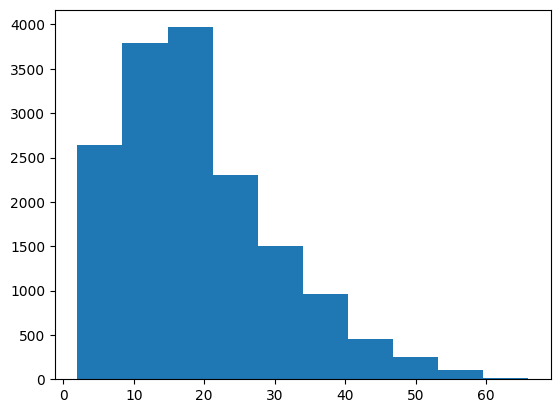

In [30]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths)
plt.show()

In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets, seq_len):
    sequences = tokenizer.texts_to_sequences(tweets)
    return pad_sequences(sequences, truncating='post', padding='post', maxlen=seq_len)

In [32]:
max_seq_len = 50


prep_train = get_sequences(tokenizer, tweets, max_seq_len)

In [33]:
prep_train

array([[   2,  139,    3, ...,    0,    0,    0],
       [   2,   40,  101, ...,    0,    0,    0],
       [  17, 3060,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  327, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]], dtype=int32)

In [34]:
def get_labels_mappers(data):
    index_to_label = {}
    label_to_index = {}
    for entry in data:
        index_to_label[entry['label']] = entry['label_text']
        label_to_index[entry['label_text']] = entry['label']
    return index_to_label, label_to_index

itl, lti = get_labels_mappers(test)
actual_labels = np.array(train['label'])

In [35]:
print(actual_labels)
print(itl)
print(lti)

[0 0 3 ... 1 3 0]
{0: 'sadness', 1: 'joy', 4: 'fear', 3: 'anger', 2: 'love', 5: 'surprise'}
{'sadness': 0, 'joy': 1, 'fear': 4, 'anger': 3, 'love': 2, 'surprise': 5}


In [55]:
# creating the model
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=max_seq_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
) 

2023-05-28 13:55:03.189741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 13:55:03.195684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 13:55:03.198102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [56]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_26 (Bidirecti  (None, 50, 40)           5920      
 onal)                                                           
                                                                 
 bidirectional_27 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [57]:
val_tweets, val_labels = get_tweet(val)
prep_val = get_sequences(tokenizer, val_tweets, max_seq_len)
actual_val_labes = np.array(val['label']) 

In [58]:
h = model.fit(
    prep_train, actual_labels,
    validation_data=(prep_val, actual_val_labes),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/20


2023-05-28 13:55:11.148301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 13:55:11.150613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 13:55:11.152861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-05-28 13:55:15.673946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 13:55:15.676678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 13:55:15.678597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

500/500 [==============================] - ETA: 0s - loss: 1.2732 - accuracy: 0.5059

2023-05-28 13:55:44.510973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 13:55:44.512950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 13:55:44.514694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

500/500 [==============================] - 36s 52ms/step - loss: 1.2732 - accuracy: 0.5059 - val_loss: 0.6720 - val_accuracy: 0.7535
Epoch 2/20
500/500 [==============================] - 22s 43ms/step - loss: 0.4128 - accuracy: 0.8564 - val_loss: 0.4429 - val_accuracy: 0.8585
Epoch 3/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2141 - accuracy: 0.9301 - val_loss: 0.3821 - val_accuracy: 0.8835
Epoch 4/20
500/500 [==============================] - 19s 38ms/step - loss: 0.1456 - accuracy: 0.9538 - val_loss: 0.3681 - val_accuracy: 0.8920
Epoch 5/20
500/500 [==============================] - 19s 37ms/step - loss: 0.1167 - accuracy: 0.9616 - val_loss: 0.3956 - val_accuracy: 0.8875
Epoch 6/20
500/500 [==============================] - 21s 42ms/step - loss: 0.0866 - accuracy: 0.9722 - val_loss: 0.4113 - val_accuracy: 0.8995
Epoch 7/20
500/500 [==============================] - 27s 55ms/step - loss: 0.0722 - accuracy: 0.9778 - val_loss: 0.4157 - val_accuracy: 0.8940
Epo

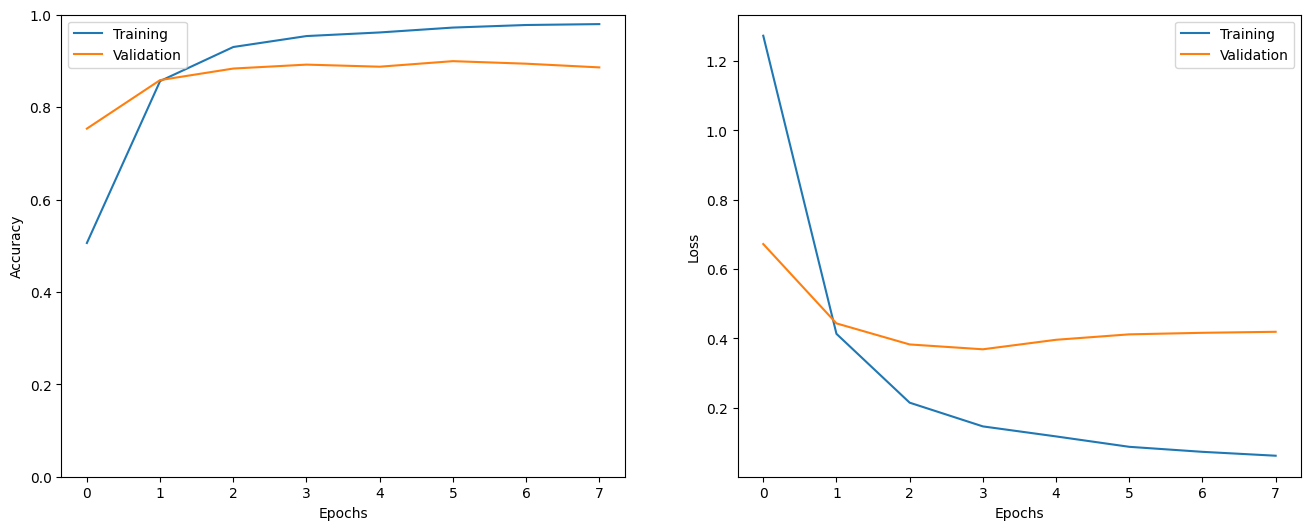

In [59]:
show_history(h)

In [60]:
test_tweets, test_labels = get_tweet(test)
prep_test = get_sequences(tokenizer, test_tweets, max_seq_len)
actual_test_labels = np.array(test['label']) 

In [61]:
_ = model.evaluate(prep_test, actual_test_labels)

63/63 [==============================] - 1s 14ms/step - loss: 0.4438 - accuracy: 0.8815


In [28]:
tf.keras.models.save_model(model,'model.h5')

In [29]:
with open('index_to_label.pkl', 'wb') as f:
    pickle.dump(itl, f)

In [30]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [33]:
sentence = "I feel very happy"
seq = tokenizer.texts_to_sequences([sentence])
bytes_seq = pad_sequences(seq, truncating='post', padding='post', maxlen=max_seq_len)

In [36]:
bytes_seq

array([[  2,   3,  46, 154,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int32)

In [37]:
p = model.predict(np.expand_dims(bytes_seq[0], axis=0))[0]

2023-05-26 13:08:51.589912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 13:08:51.593582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 13:08:51.595923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step


In [40]:
itl[np.argmax(p).astype('uint8')]

'joy'